IMPORT LIBRARY


In [15]:
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import matlab.engine

Khởi động matlab engine để sử dụng matlab trên python

In [16]:
eng = matlab.engine.start_matlab()

Trình bày và lọc nhiễu thử một file trong dataset bằng matlab
- Đọc file bằng hàm read_csv của thư viện pandas.
- Chuyển file sang dạng double của để đưa vào hàm fourier_trans_fillter bao gồm hai thông số là data , tần số lấy mãu của sensor(Fs) và kích hoạt vẽ biểu đồ .
- Kết quả trả về là mảng numpy của dữ liệu đã lọc, đồng thời biểu diễn dưới dạng biểu đồ(nếu biến verbose là true). 
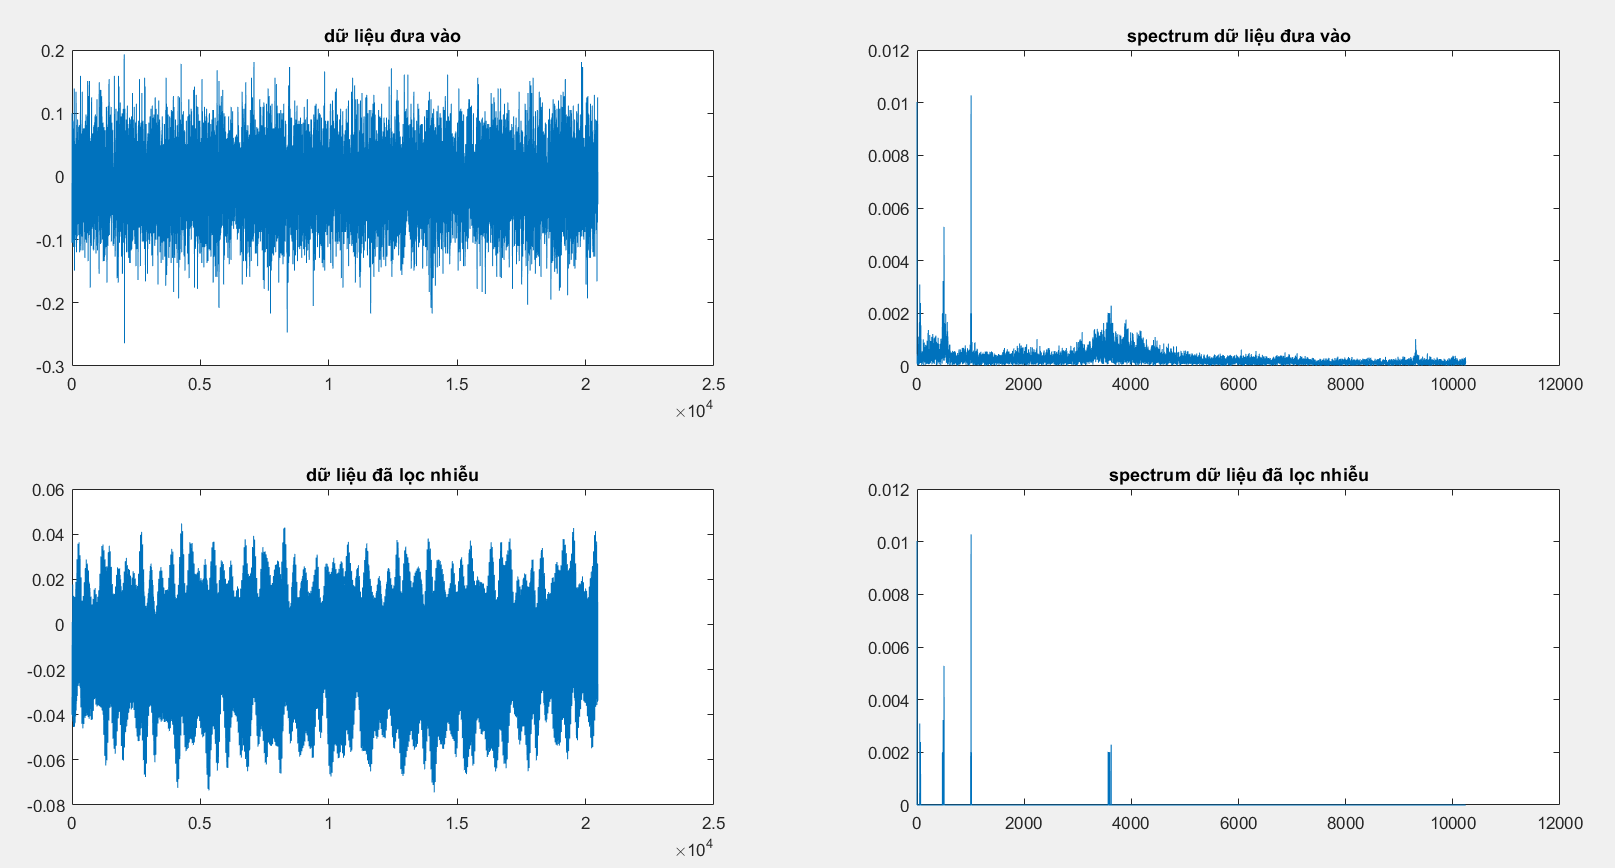

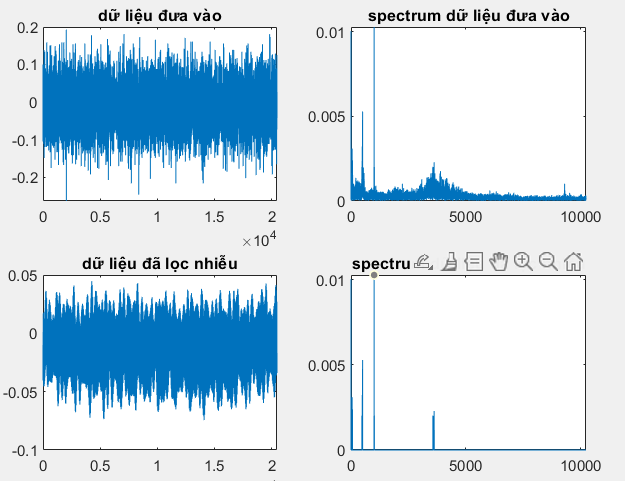

In [17]:
path=r'1st_test/1st_test'
filename = '2003.10.22.12.29.13'
dataset=pd.read_csv(os.path.join(path, filename), sep='\t',header=None)
bearing_1 = np.array(dataset.iloc[:,3])
bearing_1 = matlab.double(bearing_1.tolist())
Fs = 20000
result = eng.fourier_trans_fillter(bearing_1,Fs,True)
result = np.array(result)

In [18]:
path=r'1st_test/1st_test'
filename = '2003.10.22.12.29.13'
dataset=pd.read_csv(os.path.join(path, filename), sep='\t',header=None)
dataset

,0,1,2,3,4,5,6,7
0,-0.032,-0.181,-0.051,-0.061,-0.159,-0.088,-0.078,-0.168
1,-0.156,-0.085,-0.095,-0.139,0.020,-0.051,-0.039,-0.332
2,-0.144,-0.137,-0.015,-0.100,-0.071,-0.217,0.007,-0.083
3,-0.037,-0.225,-0.129,-0.095,-0.095,-0.061,-0.168,-0.164
4,0.020,-0.210,-0.032,-0.068,-0.051,-0.105,-0.137,-0.154
...,...,...,...,...,...,...,...,...
20475,-0.032,-0.269,-0.073,-0.100,-0.024,-0.007,-0.103,-0.225
20476,-0.059,-0.159,-0.125,-0.173,-0.125,-0.134,-0.151,-0.110
20477,-0.059,-0.146,-0.081,-0.081,-0.029,-0.171,-0.129,-0.146
20478,-0.039,-0.176,-0.110,-0.117,-0.037,-0.037,-0.039,-0.125


In [26]:
def filter(dataset,Fs,plot = False):
    dataset = matlab.double(dataset.tolist())
    result = eng.fourier_trans_fillter(dataset,Fs,plot)
    result = np.array(result)
    return result

In [37]:
def compute_skewness(x):
    
    n = len(x)
    third_moment = np.sum((x - np.mean(x))**3) / n
    s_3 = np.std(x, ddof = 1) ** 3
    third_moment= third_moment/s_3 if s_3 != 0 else 0
    return third_moment

In [38]:
def compute_kurtosis(x):
    
    n = len(x)
    fourth_moment = np.sum((x - np.mean(x))**4) / n
    s_4 = np.std(x, ddof = 1) ** 4
    fourth_moment = fourth_moment / s_4 - 3 if s_4 != 0 else 0
    return fourth_moment

In [32]:
def synthetic_data(input_path_name,output_directory,test_dataset, bearing_no, num_channel,save_csv = False):
    Time_feature_matrix=pd.DataFrame()

    path=input_path_name

    for filename in os.listdir(path):
        
        dataset=pd.read_csv(os.path.join(path, filename), sep='\t',header=None)

        bearing_data = np.array(dataset.iloc[:,num_channel-1])

        temp = filter(dataset = bearing_data,Fs=20000)

        feature_matrix=np.zeros((1,9))
        
        feature_matrix[0,0] = np.max(temp)
        feature_matrix[0,1] = np.min(temp)
        feature_matrix[0,2] = np.mean(temp)
        feature_matrix[0,3] = np.std(temp, ddof = 1)
        feature_matrix[0,4] = np.sqrt(np.mean(temp ** 2))
        feature_matrix[0,5] = compute_skewness(temp)
        feature_matrix[0,6] = compute_kurtosis(temp)
        feature_matrix[0, 7] = feature_matrix[0, 0] / feature_matrix[0, 4] if feature_matrix[0, 4] != 0 else 0
        feature_matrix[0, 8] = feature_matrix[0, 4] / feature_matrix[0, 2] if feature_matrix[0, 2] != 0 else 0
        
        df = pd.DataFrame(feature_matrix)
        df.index=[filename[:-3]]
        
        Time_feature_matrix = pd.concat([Time_feature_matrix, df])
    Time_feature_matrix.columns = ['Max','Min','Mean','Std','RMS','Skewness','Kurtosis','Crest Factor','Form Factor']
    Time_feature_matrix.index = pd.to_datetime(Time_feature_matrix.index, format='%Y.%m.%d.%H.%M')

    Time_feature_matrix = Time_feature_matrix.sort_index()

    if save_csv==True:
        channel = int(num_channel/bearing_no)

      # Đặt tên thư mục lưu trữ tại đây
        output_path = os.path.join(output_directory,'domain_feature_of_bearing_{}_channel_{}_test_{}.csv'.format(bearing_no,channel,test_dataset))
        # Tạo thư mục nếu nó không tồn tại
        os.makedirs(output_directory, exist_ok=True)
        Time_feature_matrix.to_csv(output_path)
    return Time_feature_matrix

Tạo tập data dữ liệu dưới dạng csv của tập test 1
Set No. 1:
- Recording Duration: October 22, 2003 12:06:24 to November 25, 2003 23:39:56
- No. of Files: 2,156
- No. of Channels: 8
- Channel Arrangement: Bearing 1 – Ch 1&2; Bearing 2 – Ch 3&4;
- Bearing 3 – Ch 5&6; Bearing 4 – Ch 7&8.
- File Recording Interval: Every 10 minutes (except the first 43 files were taken every 5 minutes)
- File Format: ASCII
- Description: At the end of the test-to-failure experiment, inner race defect occurred in bearing 3 and roller element defect in bearing 4

In [28]:

synthetic_data(input_path_name = "1st_test/1st_test",output_directory = "test_1_csv",
               test_dataset=1, bearing_no=1, num_channel = 1,save_csv = True)

synthetic_data(input_path_name = "1st_test/1st_test",output_directory = "test_1_csv",
               test_dataset=1, bearing_no=1, num_channel = 2,save_csv = True)

synthetic_data(input_path_name = "1st_test/1st_test",output_directory = "test_1_csv",
               test_dataset=1, bearing_no=2, num_channel = 3,save_csv = True)

synthetic_data(input_path_name = "1st_test/1st_test",output_directory = "test_1_csv",
               test_dataset=1, bearing_no=2, num_channel = 4,save_csv = True)

synthetic_data(input_path_name = "1st_test/1st_test",output_directory = "test_1_csv",
               test_dataset=1, bearing_no=3, num_channel = 5,save_csv = True)


synthetic_data(input_path_name = "1st_test/1st_test",output_directory = "test_1_csv",
               test_dataset=1, bearing_no=3, num_channel = 6,save_csv = True)

synthetic_data(input_path_name = "1st_test/1st_test",output_directory = "test_1_csv",
               test_dataset=1, bearing_no=4, num_channel = 7,save_csv = True)

synthetic_data(input_path_name = "1st_test/1st_test",output_directory = "test_1_csv",
               test_dataset=1, bearing_no=4, num_channel = 8,save_csv = True)



,Max,Min,Mean,Std,RMS,Skewness,Kurtosis,Crest Factor,Form Factor
2003-10-22 12:06:00,0.037223,-0.215401,-0.094235,0.030131,0.098935,613.931941,60945.157846,0.376240,-1.049873
2003-10-22 12:09:00,0.045065,-0.212899,-0.087946,0.030787,0.093179,380.864786,60416.285159,0.483639,-1.059501
2003-10-22 12:14:00,0.023992,-0.204819,-0.093106,0.030638,0.098017,-136.843073,59234.021583,0.244775,-1.052748
2003-10-22 12:19:00,0.022175,-0.207815,-0.093244,0.031762,0.098505,527.274614,59188.510153,0.225120,-1.056421
2003-10-22 12:24:00,0.021656,-0.220408,-0.093070,0.030872,0.098056,122.369822,59119.521184,0.220855,-1.053579
...,...,...,...,...,...,...,...,...,...
2003-11-25 16:07:00,0.492669,-0.701356,-0.114376,0.137676,0.178985,-278.604252,69442.557471,2.752564,-1.564881
2003-11-25 23:13:00,0.610197,-0.771798,-0.113415,0.154582,0.191723,-847.368992,67630.994762,3.182708,-1.690448
2003-11-25 23:19:00,0.630834,-0.767004,-0.115266,0.157811,0.195421,-1175.088856,69955.499000,3.228076,-1.695393
2003-11-25 23:29:00,0.623780,-0.905824,-0.115953,0.149834,0.189458,-624.376536,68024.741918,3.292452,-1.633922


Set No. 2:
- Recording Duration: February 12, 2004 10:32:39 to February 19, 2004 06:22:39
- No. of Files: 984
- No. of Channels: 4
- Channel Arrangement: Bearing 1 – Ch 1; Bearing2 – Ch 2; Bearing3 – Ch3; Bearing 4 – Ch 4.
- File Recording Interval: Every 10 minutes
- File Format: ASCII
- Description: At the end of the test-to-failure experiment, outer race failure occurred in bearing 1

In [36]:
synthetic_data(input_path_name = "2nd_test/2nd_test",output_directory = "test_2_csv",
               test_dataset=1, bearing_no=1, num_channel = 1,save_csv = True)

synthetic_data(input_path_name = "2nd_test/2nd_test",output_directory = "test_2_csv",
               test_dataset=1, bearing_no=2, num_channel = 2,save_csv = True)

synthetic_data(input_path_name = "2nd_test/2nd_test",output_directory = "test_2_csv",
               test_dataset=1, bearing_no=3, num_channel = 3,save_csv = True)

synthetic_data(input_path_name = "2nd_test/2nd_test",output_directory = "test_2_csv",
               test_dataset=1, bearing_no=4, num_channel = 4,save_csv = True)
    


C:\Users\dinhthang\AppData\Local\Temp\ipykernel_28668\2787414082.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return third_moment/s_3
C:\Users\dinhthang\AppData\Local\Temp\ipykernel_28668\2787414082.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return third_moment/s_3
C:\Users\dinhthang\AppData\Local\Temp\ipykernel_28668\2787414082.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return third_moment/s_3
C:\Users\dinhthang\AppData\Local\Temp\ipykernel_28668\2787414082.py:6: RuntimeWarning: invalid value encountered in scalar divide
  return third_moment/s_3


,Max,Min,Mean,Std,RMS,Skewness,Kurtosis,Crest Factor,Form Factor
2004-02-12 10:32:00,0.120821,-0.123574,-0.010026,3.109510e-02,0.032671,-1966.999524,60415.124255,3.698138,-3.258611
2004-02-12 10:42:00,0.113637,-0.146904,-0.003784,3.367420e-02,0.033885,-659.326450,60383.835605,3.353570,-8.955617
2004-02-12 10:52:00,0.119162,-0.135410,-0.003485,3.466521e-02,0.034839,356.881603,60224.160186,3.420344,-9.995877
2004-02-12 11:02:00,0.147820,-0.136758,-0.003741,3.532989e-02,0.035527,-469.433065,60380.618829,4.160839,-9.497111
2004-02-12 11:12:00,0.132812,-0.147310,-0.002703,3.567885e-02,0.035780,167.317415,60981.643293,3.711887,-13.239233
...,...,...,...,...,...,...,...,...,...
2004-02-19 05:42:00,0.470819,-0.489578,-0.002939,1.366759e-01,0.136704,-1077.527727,57216.003325,3.444074,-46.511290
2004-02-19 05:52:00,0.500086,-0.418504,-0.003315,1.039326e-01,0.103983,2669.803397,68117.956702,4.809309,-31.366108
2004-02-19 06:02:00,0.513063,-0.434996,-0.003311,1.196034e-01,0.119646,3009.941329,74792.382221,4.288163,-36.137230
2004-02-19 06:12:00,0.001786,0.001786,0.001786,6.505372e-19,0.001786,20478.500018,20475.000049,1.000000,1.000000


Set No. 3
- Recording Duration: March 4, 2004 09:27:46 to April 18, 2004 02:42:00
= No. of Files: 6,324
- No. of Channels: 4
- Channel Arrangement: Bearing1 – Ch 1; Bearing2 – Ch 2; Bearing3 – Ch3; Bearing4 – Ch4;
- File Recording Interval: Every 10 minutes
- File Format: ASCII
- Description: At the end of the test-to-failure experiment, outer race failure occurred in bearing 3

In [34]:
synthetic_data(input_path_name = "3rd_test/4th_test/txt",output_directory = "test_3_csv",
               test_dataset=1, bearing_no=1, num_channel = 1,save_csv = True)



,Max,Min,Mean,Std,RMS,Skewness,Kurtosis,Crest Factor,Form Factor
2004-03-04 09:27:00,0.211762,-0.269520,-0.004715,5.488918e-02,0.055090,-196.695574,60827.674128,3.843923,-11.684969
2004-03-04 09:32:00,0.194769,-0.231578,-0.005102,5.290216e-02,0.053146,-1092.200036,60483.208180,3.664768,-10.417748
2004-03-04 09:42:00,0.211172,-0.205846,-0.002242,5.514920e-02,0.055193,-817.846575,58976.787702,3.826038,-24.618557
2004-03-04 09:52:00,0.233444,-0.257647,-0.002552,5.786651e-02,0.057921,-991.204203,59667.031240,4.030369,-22.694266
2004-03-04 10:02:00,0.223579,-0.225948,-0.002534,5.566047e-02,0.055717,-1088.760034,58612.694775,4.012773,-21.986964
...,...,...,...,...,...,...,...,...,...
2004-04-18 02:02:00,0.604237,-0.557558,-0.002483,1.417579e-01,0.141776,3154.652481,64727.530894,4.261907,-57.095204
2004-04-18 02:12:00,0.622770,-0.487511,-0.001885,1.233700e-01,0.123381,2604.512597,60518.101685,5.047515,-65.437057
2004-04-18 02:22:00,0.601898,-0.516848,-0.002402,1.329797e-01,0.132998,6293.650114,69829.610684,4.525610,-55.379822
2004-04-18 02:32:00,0.759143,-0.488546,-0.003033,1.413901e-01,0.141419,9628.497233,81160.272820,5.368033,-46.634226


In [35]:
synthetic_data(input_path_name = "3rd_test/4th_test/txt",output_directory = "test_3_csv",
               test_dataset=1, bearing_no=2, num_channel = 2,save_csv = True)

,Max,Min,Mean,Std,RMS,Skewness,Kurtosis,Crest Factor,Form Factor
2004-03-04 09:27:00,0.273717,-0.256558,-3.904736e-03,6.957513e-02,0.069683,2178.179489,60707.170851,3.928035,-1.784574e+01
2004-03-04 09:32:00,0.261099,-0.231879,-5.114990e-03,6.345153e-02,0.063656,1337.098399,58646.989335,4.101723,-1.244495e+01
2004-03-04 09:42:00,0.288416,-0.275685,-2.249023e-03,6.588893e-02,0.065926,1402.881676,58914.176746,4.374869,-2.931303e+01
2004-03-04 09:52:00,0.277352,-0.234449,-1.115039e-03,6.592868e-02,0.065936,1274.762017,57490.764533,4.206348,-5.913380e+01
2004-03-04 10:02:00,0.261761,-0.253423,1.029992e-19,6.558728e-02,0.065586,924.682190,56954.022788,3.991128,6.367591e+17
...,...,...,...,...,...,...,...,...,...
2004-04-18 02:02:00,0.769512,-0.829784,-1.246436e-03,2.251862e-01,0.225184,1225.902360,59018.265619,3.417257,-1.806625e+02
2004-04-18 02:12:00,0.711874,-0.766876,-2.076855e-03,1.966440e-01,0.196650,137.068190,59375.313356,3.620002,-9.468652e+01
2004-04-18 02:22:00,0.797990,-0.873303,-2.420312e-03,2.419576e-01,0.241964,-670.729407,56247.215276,3.297973,-9.997214e+01
2004-04-18 02:32:00,0.925162,-1.232949,-2.095313e-03,2.488373e-01,0.248840,-3822.319944,75139.269451,3.717897,-1.187604e+02


In [33]:
synthetic_data(input_path_name = "3rd_test/4th_test/txt",output_directory = "test_3_csv",
               test_dataset=1, bearing_no=3, num_channel = 3,save_csv = True)

,Max,Min,Mean,Std,RMS,Skewness,Kurtosis,Crest Factor,Form Factor
2004-03-04 09:27:00,0.128065,-0.145391,-0.005148,3.534267e-02,0.035715,944.980806,58604.900708,3.585782,-6.937670
2004-03-04 09:32:00,0.122255,-0.136408,-0.006310,3.256109e-02,0.033166,-68.333249,59232.400564,3.686144,-5.256498
2004-03-04 09:42:00,0.136778,-0.136985,-0.001293,3.791958e-02,0.037941,-906.729995,57561.033509,3.605041,-29.349396
2004-03-04 09:52:00,0.136857,-0.146419,-0.002280,3.624883e-02,0.036320,626.827059,58889.306261,3.768140,-15.927399
2004-03-04 10:02:00,0.125311,-0.156142,-0.001727,3.586095e-02,0.035902,-173.609582,59193.893010,3.490404,-20.783729
...,...,...,...,...,...,...,...,...,...
2004-04-18 02:02:00,3.185557,-4.998202,0.017613,4.934750e-01,0.493777,-33325.086102,397061.665378,6.451406,28.034369
2004-04-18 02:12:00,2.252021,-3.799992,-0.002114,4.525255e-01,0.452519,-12810.137599,171080.898876,4.976630,-214.047076
2004-04-18 02:22:00,4.319494,-5.031194,-0.079840,5.837572e-01,0.589178,-8528.259269,315774.562828,7.331396,-7.379457
2004-04-18 02:32:00,5.020166,-5.042561,0.052137,7.564720e-01,0.758248,-4413.851562,204040.152062,6.620743,14.543321


In [31]:
synthetic_data(input_path_name = "3rd_test/4th_test/txt",output_directory = "test_3_csv",
               test_dataset=1, bearing_no=4, num_channel = 4,save_csv = True)

,Max,Min,Mean,Std,RMS,Skewness,Kurtosis,Crest Factor,Form Factor
2004-03-04 09:27:00,0.142304,-0.136600,-0.004331,3.563043e-02,0.035892,282.868478,62936.771261,3.964812,-8.287456
2004-03-04 09:32:00,0.116382,-0.143359,-0.006725,3.110942e-02,0.031827,36.924144,64586.575882,3.656674,-4.732383
2004-03-04 09:42:00,0.107317,-0.118130,-0.003200,2.883374e-02,0.029010,-433.058208,60484.775762,3.699298,-9.065371
2004-03-04 09:52:00,0.125241,-0.143255,-0.004379,3.263631e-02,0.032928,445.282622,62701.329433,3.803491,-7.519844
2004-03-04 10:02:00,0.114619,-0.123008,-0.003443,3.216350e-02,0.032346,-230.318147,60736.259019,3.543470,-9.395725
...,...,...,...,...,...,...,...,...,...
2004-04-18 02:02:00,0.799543,-0.920988,-0.003682,2.427147e-01,0.242737,-138.978565,61450.347286,3.293869,-65.928169
2004-04-18 02:12:00,0.798478,-0.794544,-0.003608,2.485551e-01,0.248575,2026.493101,56041.317882,3.212218,-68.896350
2004-04-18 02:22:00,0.985326,-1.031870,-0.003425,2.748615e-01,0.274876,-94.147201,60768.806042,3.584618,-80.245519
2004-04-18 02:32:00,0.907678,-0.968680,-0.003452,2.772790e-01,0.277294,-1994.662640,50800.689812,3.273345,-80.329528


In [42]:
df1 = pd.read_csv("test_3_csv\domain_feature_of_bearing_1_channel_1_test_1.csv",index_col='Unnamed: 0')
df2 = pd.read_csv("test_3_csv\domain_feature_of_bearing_2_channel_1_test_1.csv",index_col='Unnamed: 0')
df3 = pd.read_csv("test_3_csv\domain_feature_of_bearing_3_channel_1_test_1.csv",index_col='Unnamed: 0')
df4 = pd.read_csv("test_3_csv\domain_feature_of_bearing_4_channel_1_test_1.csv",index_col='Unnamed: 0')

In [43]:
df1.index = pd.to_datetime(df1.index)
df1

,Max,Min,Mean,Std,RMS,Skewness,Kurtosis,Crest Factor,Form Factor
2004-03-04 09:27:00,0.211762,-0.269520,-0.004715,5.488918e-02,0.055090,-196.695574,60827.674128,3.843923,-11.684969
2004-03-04 09:32:00,0.194769,-0.231578,-0.005102,5.290216e-02,0.053146,-1092.200036,60483.208180,3.664768,-10.417748
2004-03-04 09:42:00,0.211172,-0.205846,-0.002242,5.514920e-02,0.055193,-817.846575,58976.787702,3.826038,-24.618557
2004-03-04 09:52:00,0.233444,-0.257647,-0.002552,5.786651e-02,0.057921,-991.204203,59667.031240,4.030369,-22.694266
2004-03-04 10:02:00,0.223579,-0.225948,-0.002534,5.566047e-02,0.055717,-1088.760034,58612.694775,4.012773,-21.986964
...,...,...,...,...,...,...,...,...,...
2004-04-18 02:02:00,0.604237,-0.557558,-0.002483,1.417579e-01,0.141776,3154.652481,64727.530894,4.261907,-57.095204
2004-04-18 02:12:00,0.622770,-0.487511,-0.001885,1.233700e-01,0.123381,2604.512597,60518.101685,5.047515,-65.437057
2004-04-18 02:22:00,0.601898,-0.516848,-0.002402,1.329797e-01,0.132998,6293.650114,69829.610684,4.525610,-55.379822
2004-04-18 02:32:00,0.759143,-0.488546,-0.003033,1.413901e-01,0.141419,9628.497233,81160.272820,5.368033,-46.634226


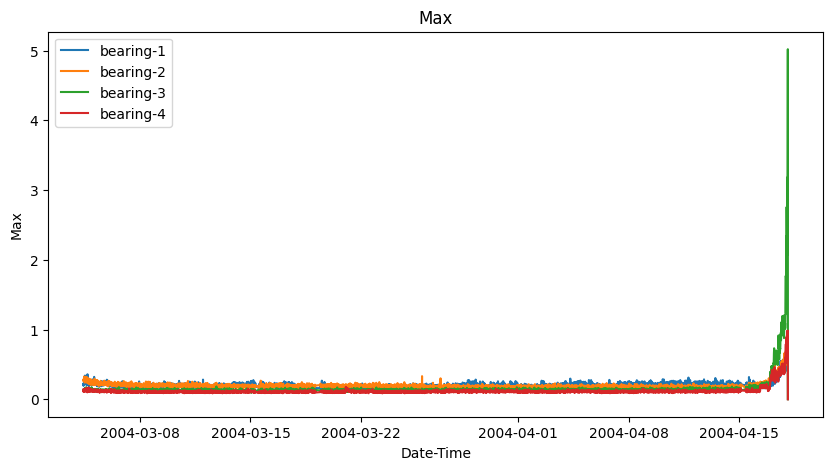

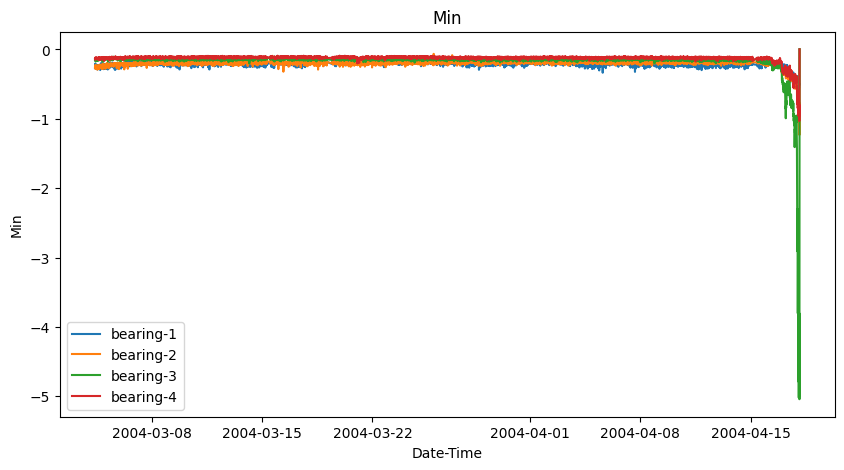

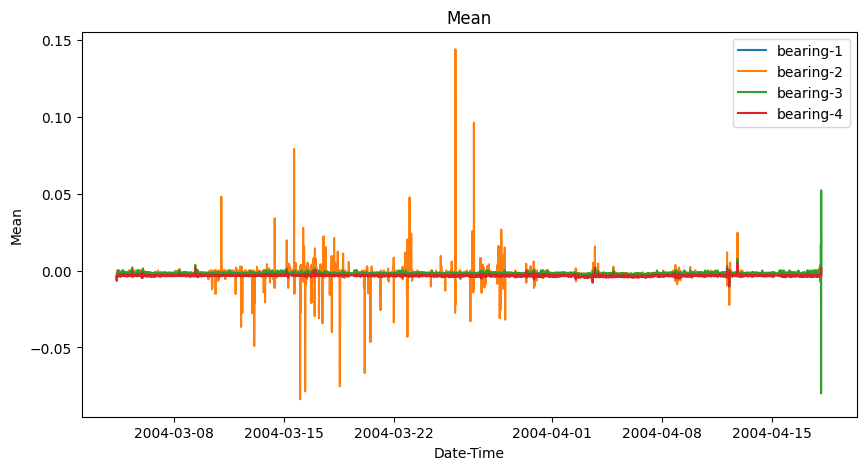

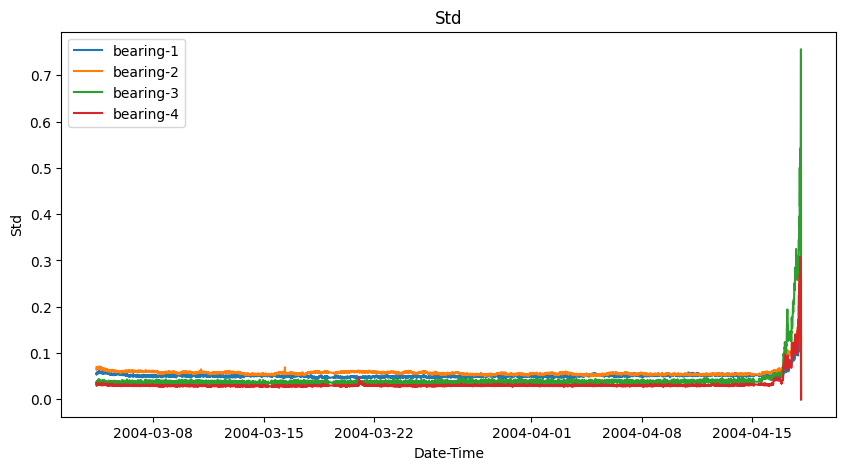

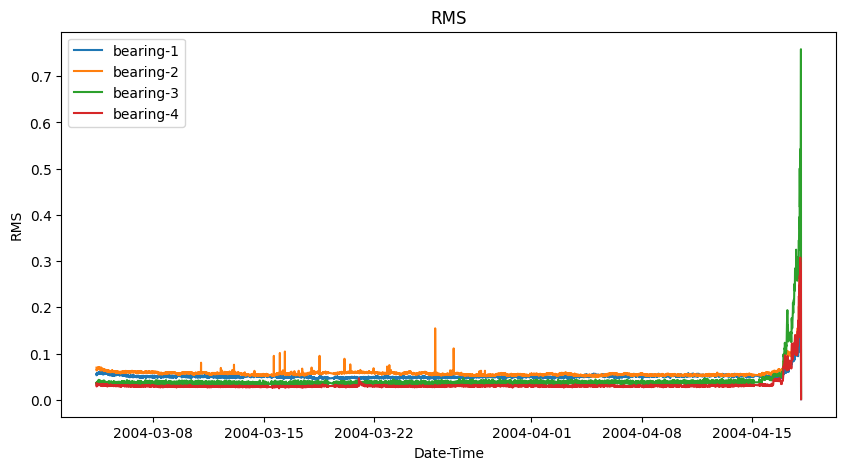

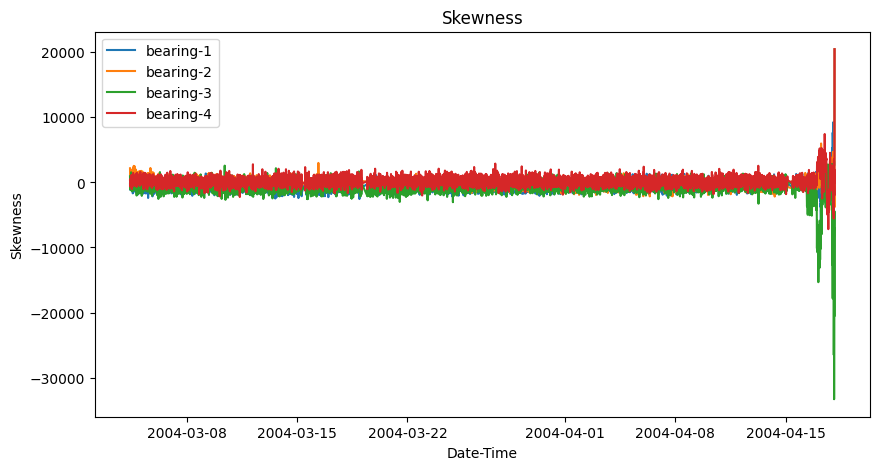

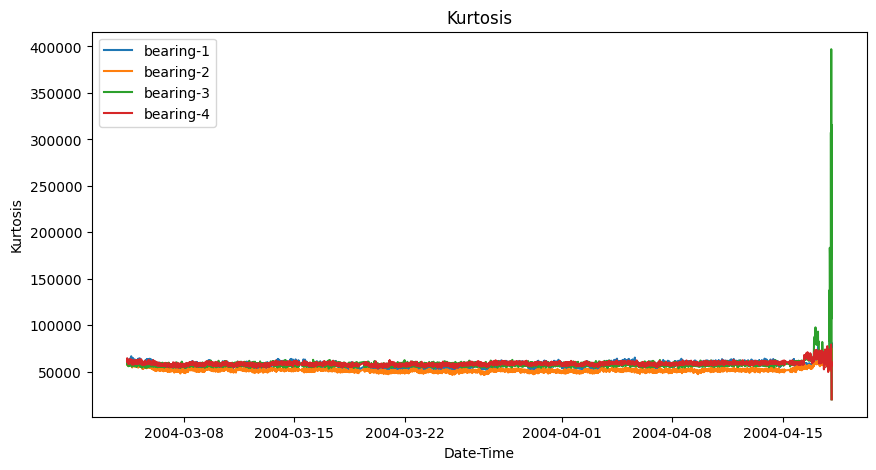

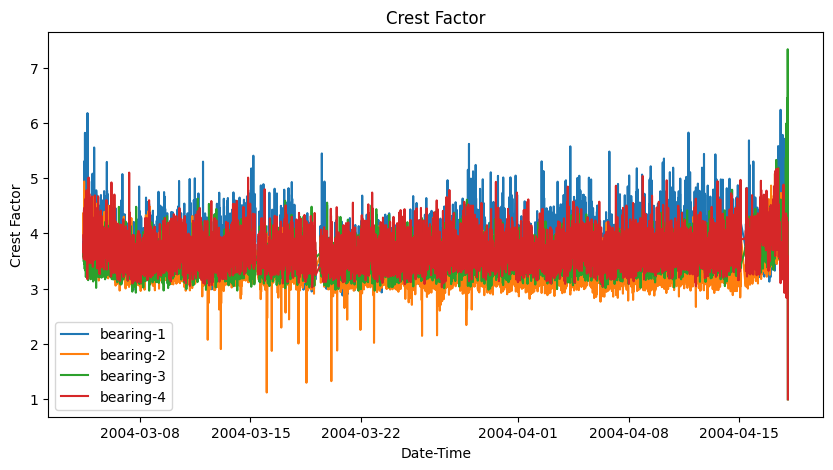

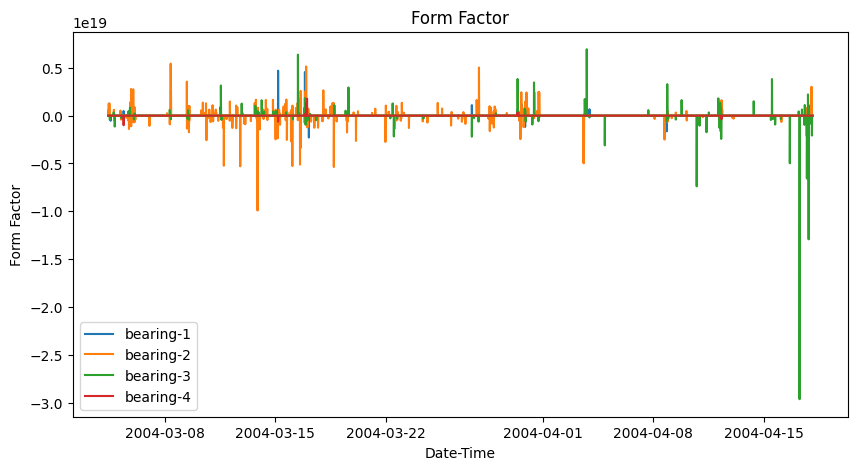

In [44]:
for col in (df1.columns):  
    
        plt.figure(figsize=(10, 5))
        plt.plot(df1.index,df1[col])
        plt.plot(df1.index,df2[col])
        plt.plot(df1.index,df3[col])
        plt.plot(df1.index,df4[col])

        plt.legend(['bearing-1','bearing-2','bearing-3','bearing-4'])

        plt.xlabel("Date-Time")
        plt.ylabel(col)
        plt.title(col)
        plt.show()

In [45]:
df1 = pd.read_csv("test_2_csv\domain_feature_of_bearing_1_channel_1_test_1.csv",index_col='Unnamed: 0')
df2 = pd.read_csv("test_2_csv\domain_feature_of_bearing_2_channel_1_test_1.csv",index_col='Unnamed: 0')
df3 = pd.read_csv("test_2_csv\domain_feature_of_bearing_3_channel_1_test_1.csv",index_col='Unnamed: 0')
df4 = pd.read_csv("test_2_csv\domain_feature_of_bearing_4_channel_1_test_1.csv",index_col='Unnamed: 0')

In [47]:
df1.index = pd.to_datetime(df1.index)

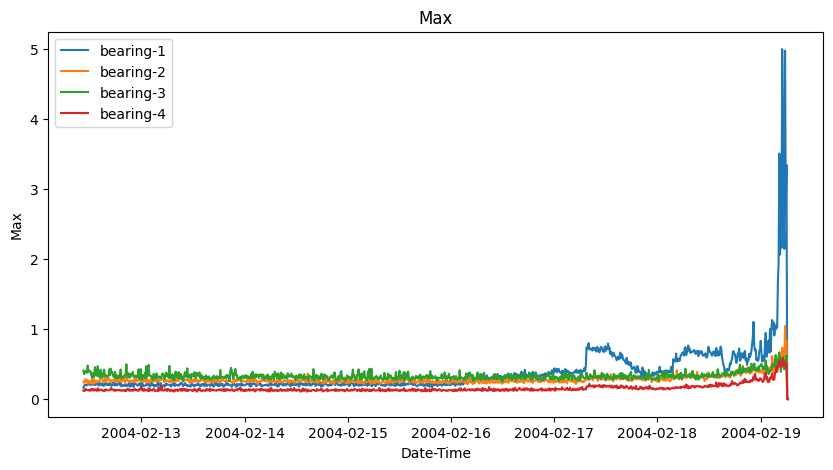

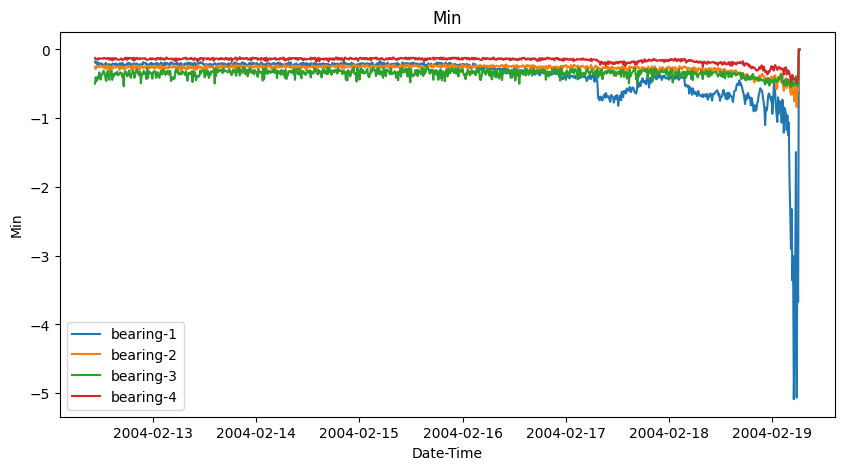

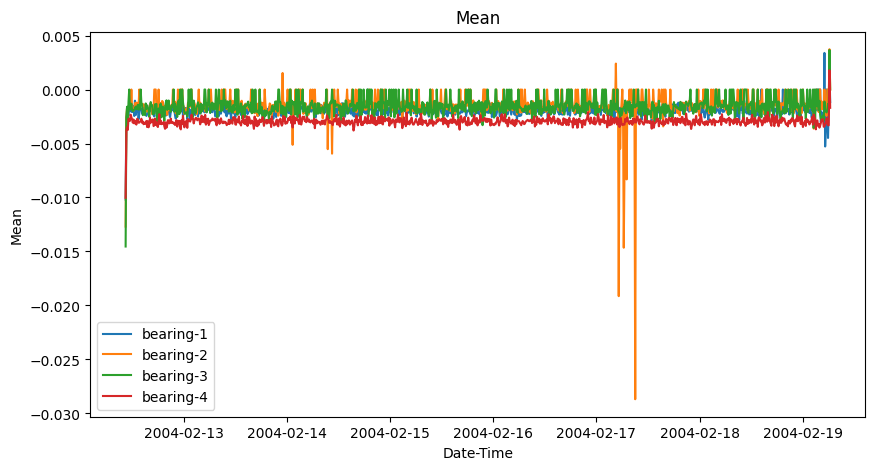

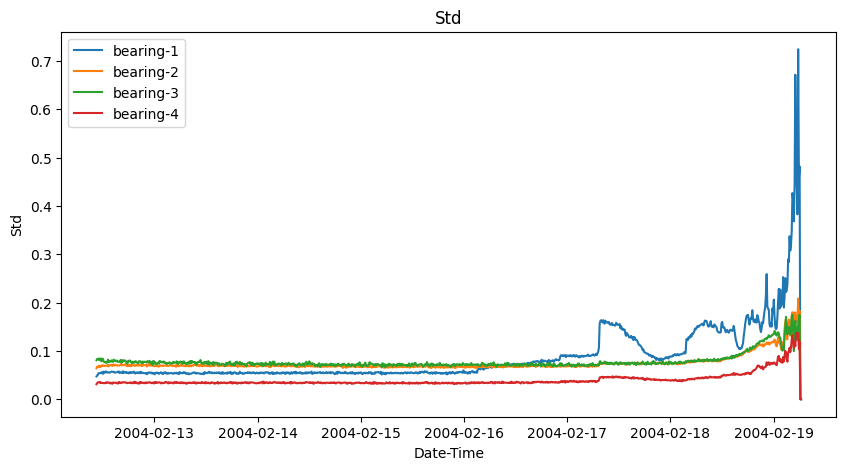

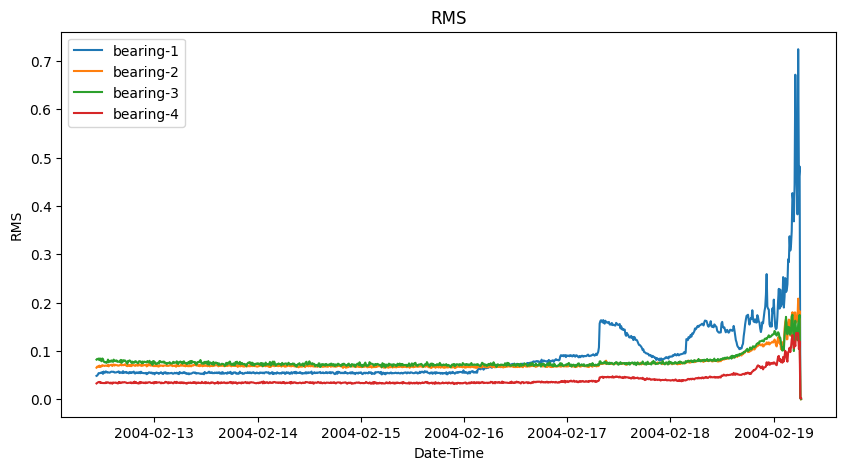

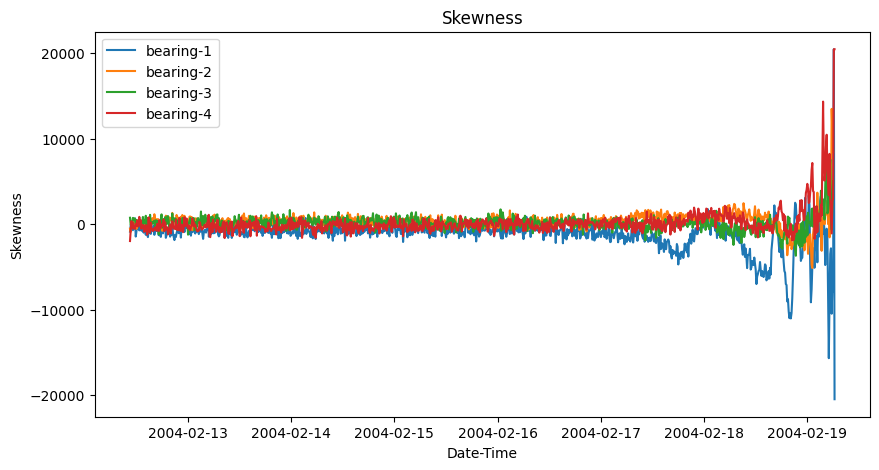

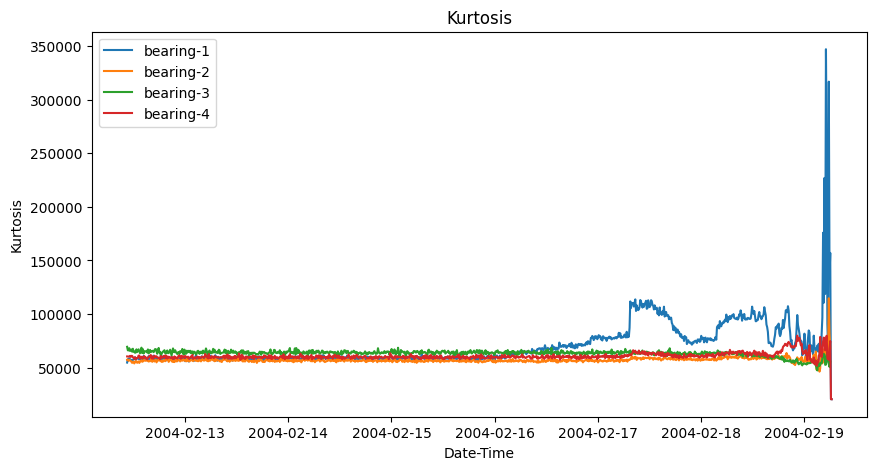

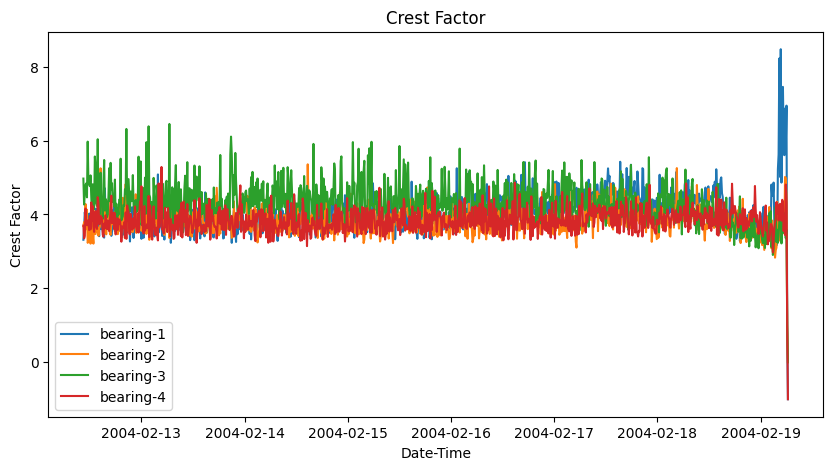

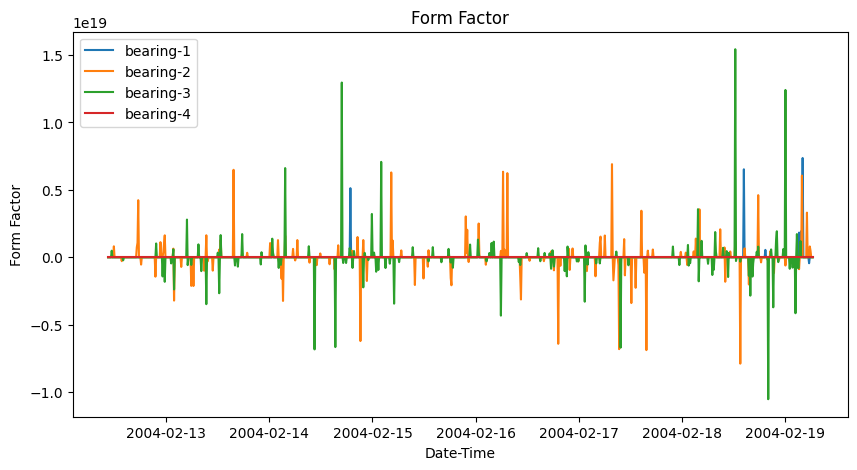

In [48]:
for col in (df1.columns):  
    
        plt.figure(figsize=(10, 5))
        plt.plot(df1.index,df1[col])
        plt.plot(df1.index,df2[col])
        plt.plot(df1.index,df3[col])
        plt.plot(df1.index,df4[col])

        plt.legend(['bearing-1','bearing-2','bearing-3','bearing-4'])

        plt.xlabel("Date-Time")
        plt.ylabel(col)
        plt.title(col)
        plt.show()

In [51]:
df1 = pd.read_csv("test_1_csv\domain_feature_of_bearing_1_channel_1_test_1.csv",index_col='Unnamed: 0')
df2 = pd.read_csv("test_1_csv\domain_feature_of_bearing_2_channel_1_test_1.csv",index_col='Unnamed: 0')
df3 = pd.read_csv("test_1_csv\domain_feature_of_bearing_3_channel_1_test_1.csv",index_col='Unnamed: 0')
df4 = pd.read_csv("test_1_csv\domain_feature_of_bearing_4_channel_1_test_1.csv",index_col='Unnamed: 0')

In [52]:
df1.index = pd.to_datetime(df1.index)

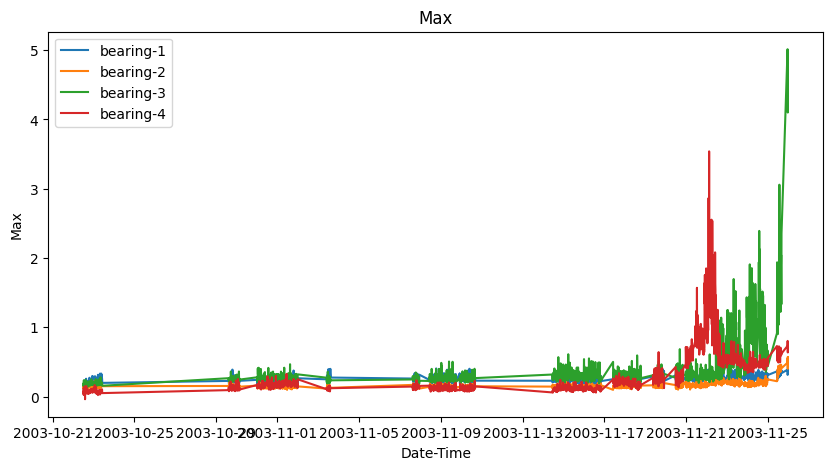

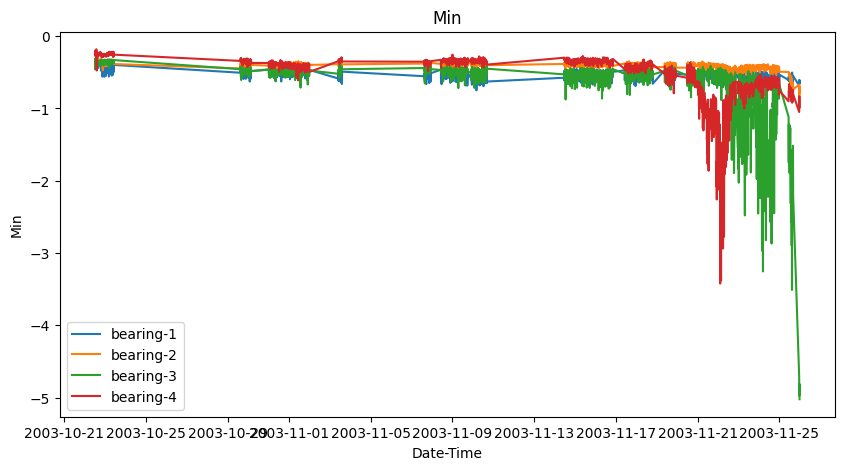

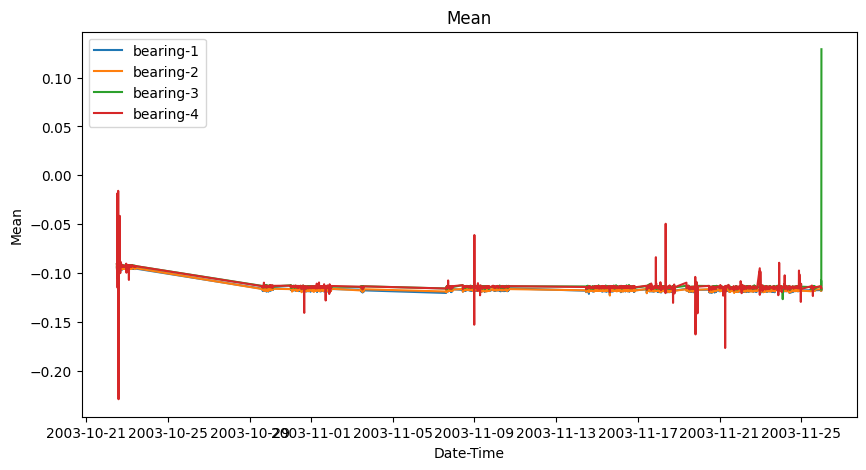

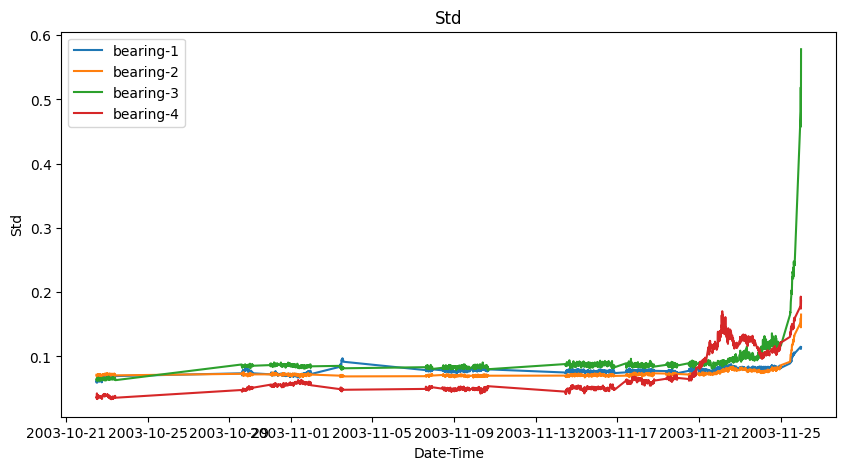

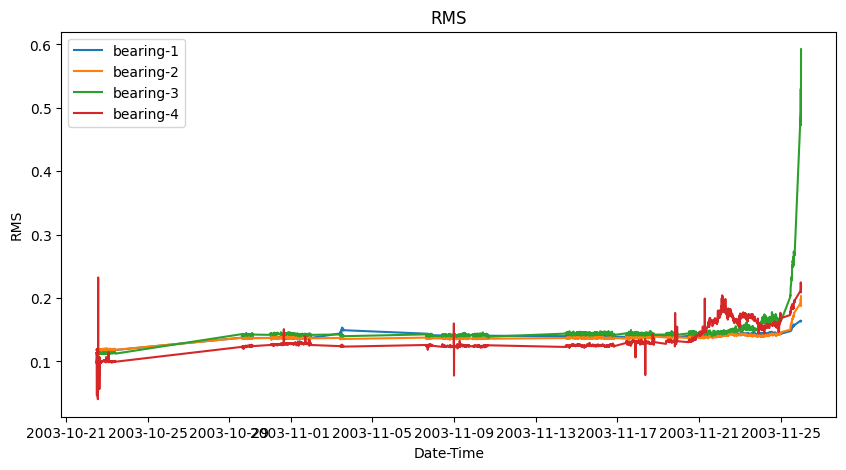

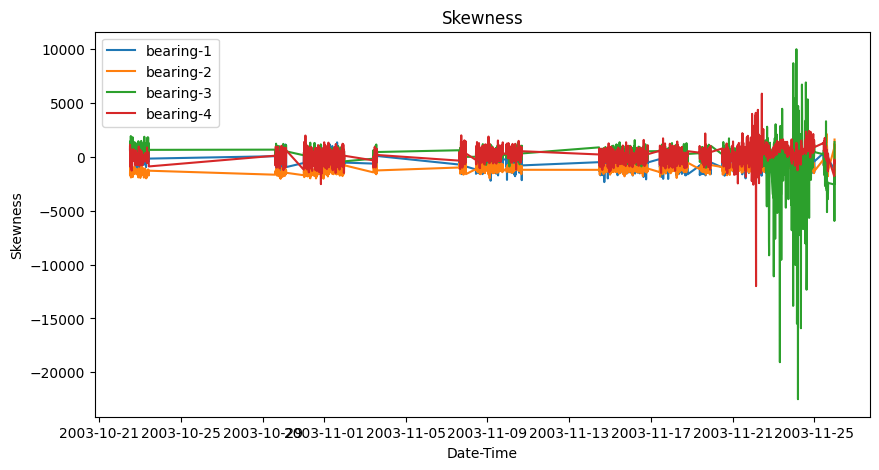

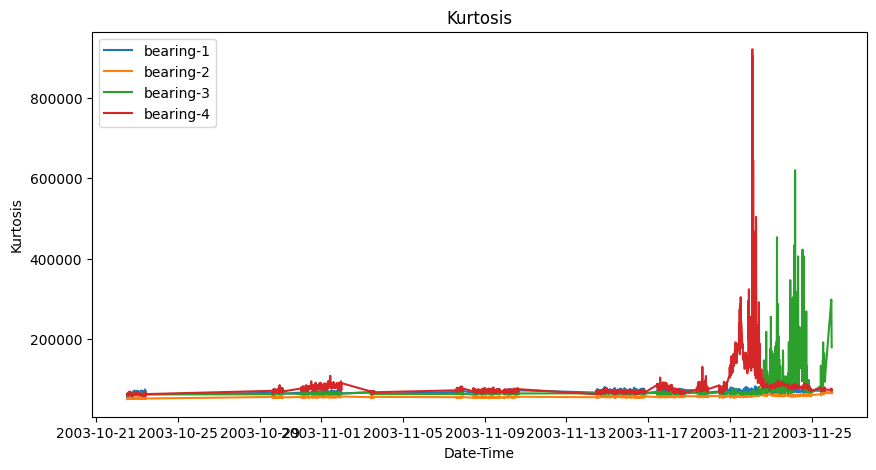

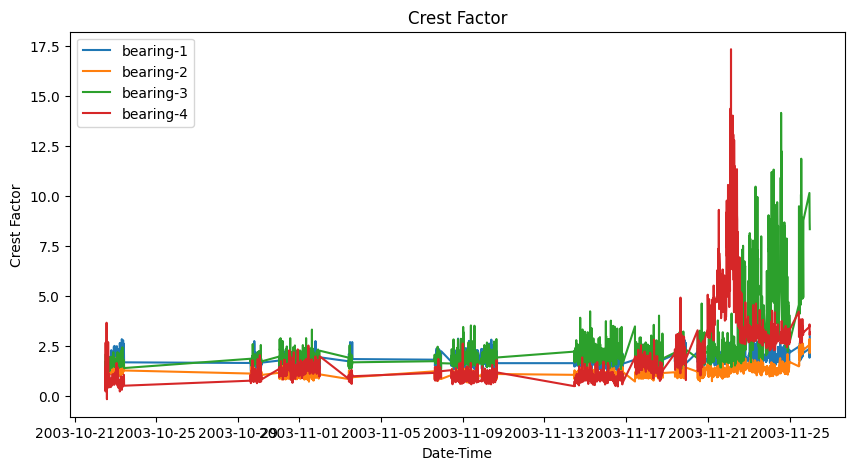

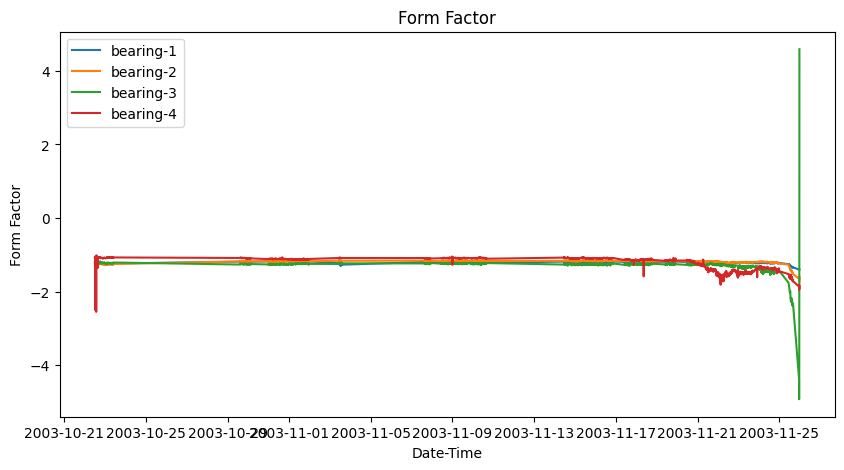

In [53]:
for col in (df1.columns):  
    
        plt.figure(figsize=(10, 5))
        plt.plot(df1.index,df1[col])
        plt.plot(df1.index,df2[col])
        plt.plot(df1.index,df3[col])
        plt.plot(df1.index,df4[col])

        plt.legend(['bearing-1','bearing-2','bearing-3','bearing-4'])

        plt.xlabel("Date-Time")
        plt.ylabel(col)
        plt.title(col)
        plt.show()